# SegNet

In this work I implemented a SegNet without skip connections. It is not implemented in keras yet. You can find the article here : https://arxiv.org/pdf/1511.00561.pdf

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
import cv2
import os
import matplotlib.pyplot as plt

np.random.seed(1337) # for reproducibility

path = './CamVid/'
data_shape = 360*480

%matplotlib inline

Using TensorFlow backend.


## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [2]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

In [3]:
def normalized(rgb):
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        train_data.append(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])))
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
    return np.array(train_data), np.array(train_label)

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb


In [4]:
train_data, train_label_annot = prep_data()
train_label = np.reshape(train_label_annot,(367,data_shape,12))

In [5]:
train_data.shape , train_label.shape

((367, 360, 480, 3), (367, 172800, 12))

In [6]:
gt = []
with open(path+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

Lets visualize some training data:

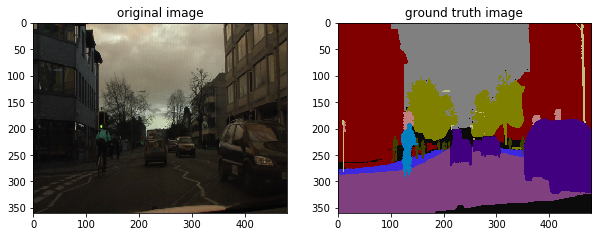

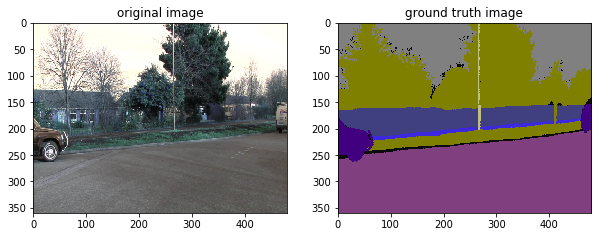

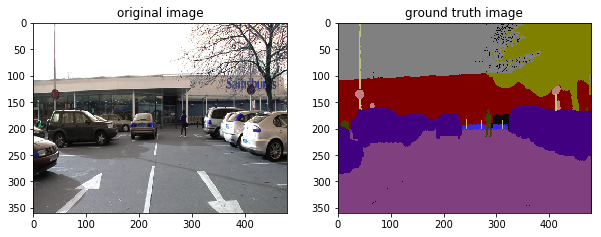

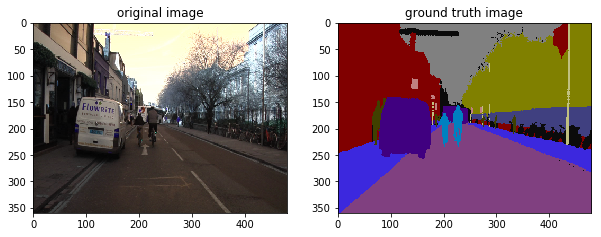

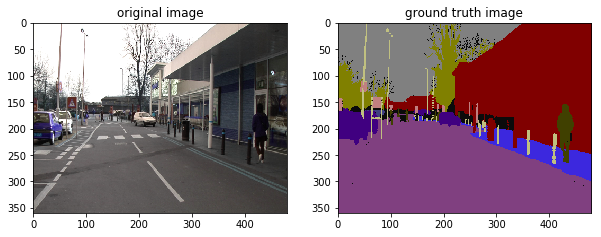

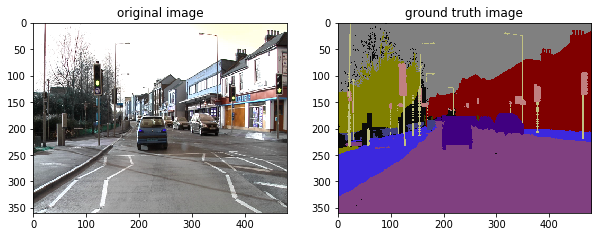

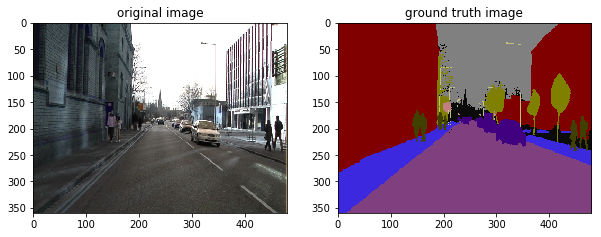

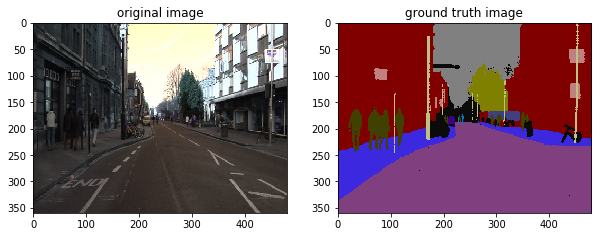

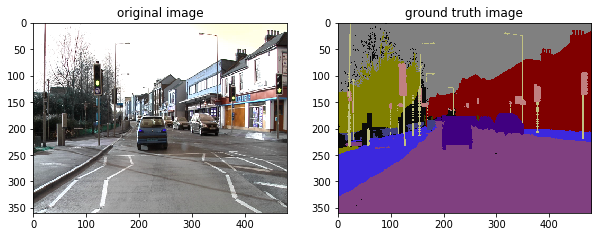

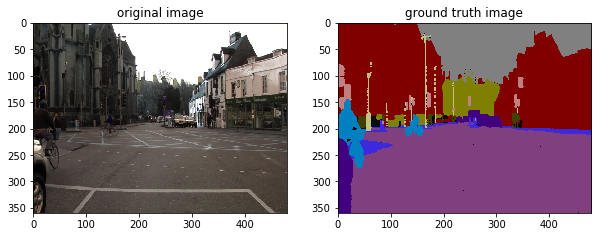

In [18]:
for i in range(10):
    plt.figure(figsize=(10,15))
    
    ind = np.random.randint(0, train_data.shape[0])
    img = train_data[ind,:,:,:]
    plt.subplot(1,2,1)
    plt.imshow(gt[ind])
    plt.title("original image")
    
    plt.subplot(1,2,2)
    img_annot = visualize(np.argmax(train_label[ind,:,:],axis=1).reshape((360,480)), False)
    plt.imshow(img_annot)
    plt.title("ground truth image")

In [8]:
# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

### Creating the model

In [9]:
pad = 1
kernel = 3
pool_size = 2

SegNet = models.Sequential()

SegNet.add(Layer(input_shape = (360, 480, 3)))

## encoder
SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(64, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())
SegNet.add(Activation('relu'))
SegNet.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())
SegNet.add(Activation('relu'))
SegNet.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())
SegNet.add(Activation('relu'))
SegNet.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())
SegNet.add(Activation('relu'))

## decoder
SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())

SegNet.add(UpSampling2D(size=(pool_size, pool_size)))
SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())

SegNet.add(UpSampling2D(size=(pool_size, pool_size)))
SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())

SegNet.add(UpSampling2D(size=(pool_size, pool_size)))
SegNet.add(ZeroPadding2D(padding=(pad,pad)))
SegNet.add(Convolution2D(64, kernel, kernel, border_mode='valid'))
SegNet.add(BatchNormalization())

SegNet.add(Convolution2D(12, 1, 1, border_mode='valid'))
SegNet.add(Reshape((12,data_shape)))
SegNet.add(Permute((2, 1)))
SegNet.add(Activation('softmax'))

SegNet.compile(loss="categorical_crossentropy", optimizer='adam')

c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_1_model" was not an Input tensor, it was generated by layer layer_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: layer_input_1:0
  str(x.name))


## Training 


In [49]:
SegNet.load_weights('keras_tf_model_weight_ep300.hdf5')

nb_epoch = 100
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep400.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Epoch 1/100
367/367 [==============================] - 78s - loss: 0.7498    
Epoch 2/100
367/367 [==============================] - 61s - loss: 0.8404    
Epoch 3/100
367/367 [==============================] - 55s - loss: 0.6574    
Epoch 4/100
367/367 [==============================] - 55s - loss: 0.5908    
Epoch 5/100
367/367 [==============================] - 55s - loss: 0.4905    
Epoch 6/100
367/367 [==============================] - 55s - loss: 0.4369    
Epoch 7/100
367/367 [==============================] - 56s - loss: 0.4119    
Epoch 8/100
367/367 [==============================] - 55s - loss: 0.4005    
Epoch 9/100
367/367 [==============================] - 55s - loss: 0.4028    
Epoch 10/100
367/367 [==============================] - 57s - loss: 0.4061    
Epoch 11/100
367/367 [==============================] - 55s - loss: 0.4011    
Epoch 12/100
367/367 [==============================] - 56s - loss: 0.3946    
Epoch 13/100
367/367 [==============================] - 56s -

In [50]:
nb_epoch = 200
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep600.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Epoch 1/200
367/367 [==============================] - 55s - loss: 0.2643    
Epoch 2/200
367/367 [==============================] - 55s - loss: 0.2694    
Epoch 3/200
367/367 [==============================] - 54s - loss: 0.2616    
Epoch 4/200
367/367 [==============================] - 54s - loss: 0.2646    
Epoch 5/200
367/367 [==============================] - 54s - loss: 0.2688    
Epoch 6/200
367/367 [==============================] - 55s - loss: 0.2693    
Epoch 7/200
367/367 [==============================] - 54s - loss: 0.2608    
Epoch 8/200
367/367 [==============================] - 54s - loss: 0.2669    
Epoch 9/200
367/367 [==============================] - 55s - loss: 0.2612    
Epoch 10/200
367/367 [==============================] - 55s - loss: 0.2569    
Epoch 11/200
367/367 [==============================] - 55s - loss: 0.2602    
Epoch 12/200
367/367 [==============================] - 54s - loss: 0.2624    
Epoch 13/200
367/367 [==============================] - 54s -

In [51]:
nb_epoch = 200
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep800.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Epoch 1/200
367/367 [==============================] - 55s - loss: 0.1928    
Epoch 2/200
367/367 [==============================] - 55s - loss: 0.1882    
Epoch 3/200
367/367 [==============================] - 55s - loss: 0.1841    
Epoch 4/200
367/367 [==============================] - 55s - loss: 0.1831    
Epoch 5/200
367/367 [==============================] - 55s - loss: 0.1860    
Epoch 6/200
367/367 [==============================] - 55s - loss: 0.1830    
Epoch 7/200
367/367 [==============================] - 55s - loss: 0.1829    
Epoch 8/200
367/367 [==============================] - 55s - loss: 0.1835    
Epoch 9/200
367/367 [==============================] - 55s - loss: 0.1833    
Epoch 10/200
367/367 [==============================] - 55s - loss: 0.1827    
Epoch 11/200
367/367 [==============================] - 55s - loss: 0.1823    
Epoch 12/200
367/367 [==============================] - 55s - loss: 0.1827    
Epoch 13/200
367/367 [==============================] - 55s -

In [52]:
nb_epoch = 200
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep1000.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Epoch 1/200


c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


367/367 [==============================] - 54s - loss: 0.1537    
Epoch 2/200
367/367 [==============================] - 55s - loss: 0.1557    
Epoch 3/200
367/367 [==============================] - 55s - loss: 0.1557    
Epoch 4/200
367/367 [==============================] - 55s - loss: 0.1541    
Epoch 5/200
367/367 [==============================] - 55s - loss: 0.1562    
Epoch 6/200
367/367 [==============================] - 55s - loss: 0.1556    
Epoch 7/200
367/367 [==============================] - 55s - loss: 0.1562    
Epoch 8/200
367/367 [==============================] - 55s - loss: 0.1538    
Epoch 9/200
367/367 [==============================] - 55s - loss: 0.1567    
Epoch 10/200
367/367 [==============================] - 55s - loss: 0.1557    
Epoch 11/200
367/367 [==============================] - 55s - loss: 0.1535    
Epoch 12/200
367/367 [==============================] - 55s - loss: 0.1548    
Epoch 13/200
367/367 [==============================] - 55s - loss: 0.156

In [53]:
nb_epoch = 200
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep1200.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Epoch 1/200


c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


367/367 [==============================] - 55s - loss: 0.1392    
Epoch 2/200
367/367 [==============================] - 55s - loss: 0.1384    
Epoch 3/200
367/367 [==============================] - 55s - loss: 0.1365    
Epoch 4/200
367/367 [==============================] - 55s - loss: 0.1341    
Epoch 5/200
367/367 [==============================] - 55s - loss: 0.1337    
Epoch 6/200
367/367 [==============================] - 55s - loss: 0.1367    
Epoch 7/200
367/367 [==============================] - 55s - loss: 0.1386    
Epoch 8/200
367/367 [==============================] - 55s - loss: 0.1373    
Epoch 9/200
367/367 [==============================] - 55s - loss: 0.1361    
Epoch 10/200
367/367 [==============================] - 55s - loss: 0.1376    
Epoch 11/200
367/367 [==============================] - 55s - loss: 0.1369    
Epoch 12/200
367/367 [==============================] - 55s - loss: 0.1359    
Epoch 13/200
367/367 [==============================] - 55s - loss: 0.136

In [54]:
nb_epoch = 200
batch_size = 5

history = SegNet.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting )#, validation_data=(X_test, X_test))
SegNet.save_weights('keras_tf_model_weight_ep1400.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Epoch 1/200


c:\users\ekargar\appdata\local\programs\python\python35\lib\site-packages\keras\models.py:654: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


367/367 [==============================] - 55s - loss: 0.1240    
Epoch 2/200
367/367 [==============================] - 55s - loss: 0.1253    
Epoch 3/200
367/367 [==============================] - 55s - loss: 0.1249    
Epoch 4/200
367/367 [==============================] - 55s - loss: 0.1248    
Epoch 5/200
367/367 [==============================] - 55s - loss: 0.1256    
Epoch 6/200
367/367 [==============================] - 55s - loss: 0.1277    
Epoch 7/200
367/367 [==============================] - 55s - loss: 0.1229    
Epoch 8/200
367/367 [==============================] - 55s - loss: 0.1262    
Epoch 9/200
367/367 [==============================] - 55s - loss: 0.1264    
Epoch 10/200
367/367 [==============================] - 55s - loss: 0.1254    
Epoch 11/200
367/367 [==============================] - 55s - loss: 0.1240    
Epoch 12/200
367/367 [==============================] - 55s - loss: 0.1257    
Epoch 13/200
367/367 [==============================] - 55s - loss: 0.125

### Visualize some network outputs

In [10]:
SegNet.load_weights('keras_tf_model_weight_ep1400.hdf5')

1/1 [==============================] - 0s


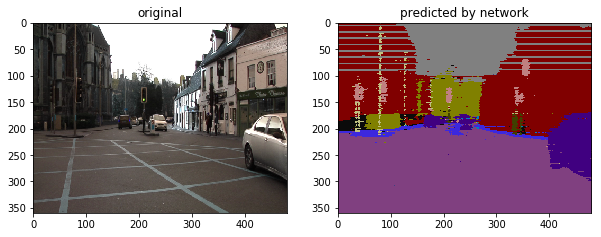

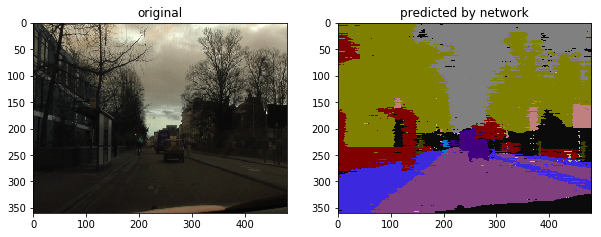

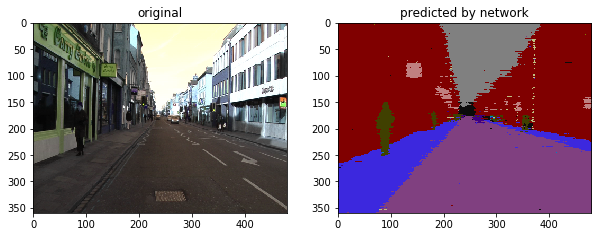

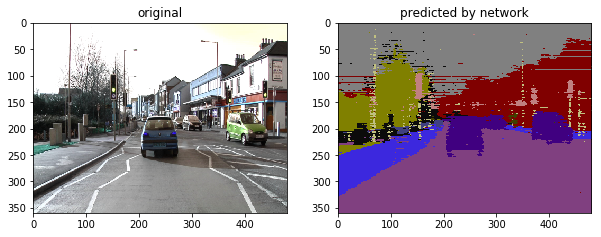

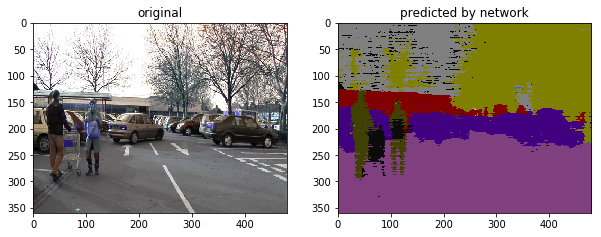

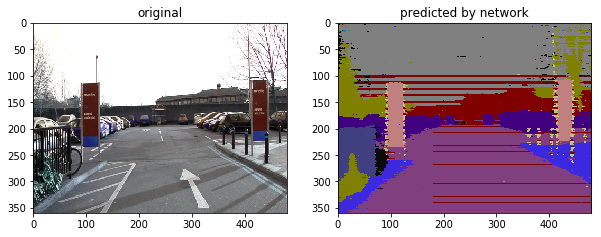

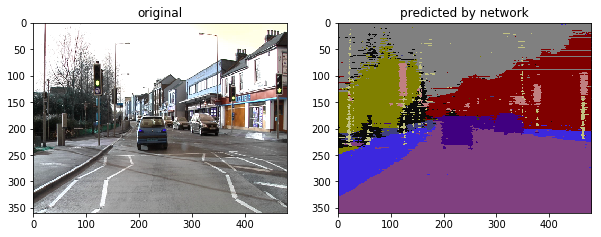

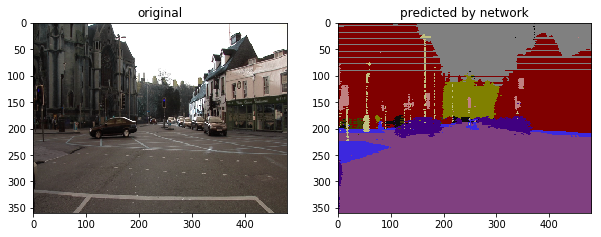

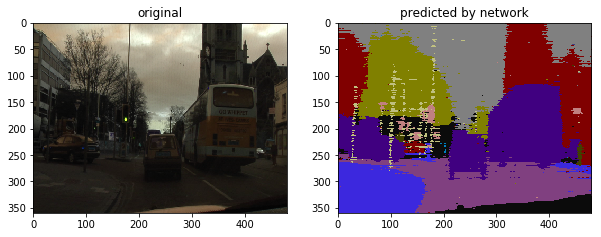

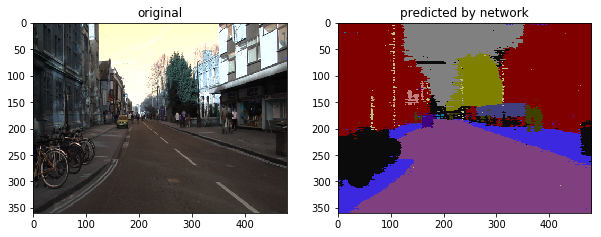

In [19]:
for i in range(10):
    plt.figure(figsize=(10,15))

    ind = np.random.randint(0, train_data.shape[0])
    plt.subplot(1,2,1)
    plt.imshow(gt[ind])
    plt.title("original")
    
    plt.subplot(1,2,2)
    output = SegNet.predict_proba(train_data[ind:ind+1])
    pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
    plt.imshow(pred)
    plt.title("predicted by network")